# ++ Carregar dados históricos da Bovespa em Dataframe para análise ++

In [1]:
import time
time.asctime( time.localtime(time.time()) )

'Wed Jun 26 12:41:28 2024'

In [23]:
import pandas as pd
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display
pd.__version__

'2.0.3'

In [3]:
from IPython.display import FileLink, FileLinks
FileLink('Resultados.ipynb')

C:\Users\esmer\Desktop\Alexandre\Projeto Git\StockManager\Resultados.ipynb

In [4]:
# Setando opção do Pandas para mostrar todas as linhas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Setando separador de milhar
pd.options.display.float_format = '{:,.2f}'.format

In [5]:
from pacote.functions import *

In [6]:
ano = time.localtime().tm_year
if time.localtime().tm_mon < 3:
    str_ano, str_nov_ant, str_dez_ant = f'A{ano}', f'M11{ano-1}', f'M12{ano-1}'
    LISTA_ARQUIVOS = [str_ano, str_nov_ant, str_dez_ant]
else:
    str_ano = f'A{ano}'
    LISTA_ARQUIVOS = [str_ano]

In [7]:
df = carrega_dados(LISTA_ARQUIVOS)

In [8]:
from IPython.display import Markdown, display
import pandas_market_calendars as mcal

# Busca data do último pregão
calendario = mcal.get_calendar("BMF")
ontem = datetime.date(datetime.today() - timedelta(days=1))
dt_ultimo_bmf = datetime.date(calendario.schedule(start_date=f"{ano}-01-01", end_date=ontem)['market_open'].max())

dt_max = datetime.date(df["dtPregao"].max())

if dt_ultimo_bmf == dt_max:
    font_color="alert-success"
    a = "Atualizado!"
else:
    font_color="alert-danger"
    a = "Desatualizado!!! Última data " + str(dt_max)
def printmd(string):
    display(Markdown(string))

In [33]:
#  df_n_dias | vol | col_pc | pc_min | avg_vr_fech
parm_vol = 6000000

max_count = 7
bar = IntProgress(min=0, max=max_count) # instantiate the bar
display(bar) # display the bar

d25 = monta_tabela(monta_df_periodos(df, 25), parm_vol, '1.0%', 22, 1)
bar.value += 1
d20 = monta_tabela(monta_df_periodos(df, 20), parm_vol, '1.0%', 18, 1)
bar.value += 1
d15 = monta_tabela(monta_df_periodos(df, 15), parm_vol, '1.0%', 14, 1)
bar.value += 1
d10 = monta_tabela(monta_df_periodos(df, 10), parm_vol, '1.0%', 10, 1)
bar.value += 1
d05 = monta_tabela(monta_df_periodos(df, 5), parm_vol, '1.0%', 5, 1)
bar.value += 1
d04 = monta_tabela(monta_df_periodos(df, 4), parm_vol, '1.0%', 4, 1)
bar.value += 1
d03 = monta_tabela(monta_df_periodos(df, 3), parm_vol, '1.0%', 3, 1)
bar.value += 1
merge1 = pd.merge(d25['cdAcao'], d20['cdAcao'], how ='inner', on =['cdAcao'])
merge2 = pd.merge(merge1, d15['cdAcao'], how ='inner', on =['cdAcao'])
merge3 = pd.merge(merge2, d10['cdAcao'], how ='inner', on =['cdAcao'])
merge_final = pd.merge(merge3, d05['cdAcao'], how ='inner', on =['cdAcao'])

IntProgress(value=0, max=7)

In [10]:
printmd(f'**<div class={font_color}>Arquivo {a}</div>**')

**<div class=alert-success>Arquivo Atualizado!</div>**

### 25 dias, order by 1%

In [11]:
d25

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,AvgVol,AvgVrFech,AvgPcAbert
756,DASA3,24,23,21,20,20,18,"10,386,013.44",3.75,0.80
1693,QUAL3,24,22,19,18,10,9,"7,417,878.76",1.62,0.30
926,EZTC3,23,22,14,9,7,7,"23,353,970.60",13.16,0.14


### 20 dias, order by 1%

In [12]:
d20

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,AvgVol,AvgVrFech,AvgPcAbert
912,EZTC3,19,19,13,8,6,6,"22,589,633.65",13.10,0.21
747,DASA3,19,18,17,16,16,14,"11,830,123.90",3.72,1.11
1667,QUAL3,20,18,15,14,9,8,"7,730,378.75",1.61,0.28


### 15 dias, order by 1%

In [13]:
d15

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,AvgVol,AvgVrFech,AvgPcAbert
158,AZEV4,15,15,15,13,13,13,"8,077,544.00",1.29,1.38
882,EZTC3,14,14,10,6,5,5,"21,965,687.20",13.14,0.13


### 10 dias, order by 1%

In [14]:
d10

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,AvgVol,AvgVrFech,AvgPcAbert
155,AZEV4,10,10,10,8,8,8,"9,547,385.00",1.35,2.24
1804,SOMA3,10,10,7,7,7,2,"61,434,861.30",5.88,0.12


### 5 dias, order by 1%

In [15]:
d05

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,AvgVol,AvgVrFech,AvgPcAbert
147,AZEV4,5,5,5,5,5,5,"14,871,700.80",1.48,3.24
103,AMBP3,5,5,5,4,4,4,"18,334,998.20",9.72,-0.63
887,GFSA3,5,5,5,4,4,4,"12,519,065.60",3.53,0.39
1510,RAPT4,5,5,5,4,4,4,"33,379,378.20",10.24,1.82
1363,ONCO3,5,5,5,4,3,3,"25,257,018.20",5.81,0.61
1552,RENT3,5,5,5,4,2,1,"400,349,286.60",41.15,-0.16
1694,SOMA3,5,5,4,4,4,1,"70,350,546.60",5.92,0.18
268,BHIA3,5,5,4,4,3,3,"19,697,217.80",5.76,0.35
1708,STBP3,5,5,4,4,3,3,"66,414,046.20",13.17,0.12
1877,VIVA3,5,5,4,4,3,3,"69,485,576.80",20.60,0.30


In [16]:
d04

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,AvgVol,AvgVrFech,AvgPcAbert
142,AZEV4,4,4,4,4,4,4,"13,918,041.75",1.49,2.89
543,COGN3,4,4,4,4,4,3,"74,712,170.75",1.73,-0.14
701,ECOR3,4,4,4,4,4,2,"34,166,916.75",6.51,0.49
603,CURY3,4,4,4,4,3,3,"40,843,505.75",19.48,0.25
1238,MRVE3,4,4,4,4,2,2,"66,066,971.50",6.79,0.27
874,GGPS3,4,4,4,4,2,0,"34,006,439.25",17.27,0.34
100,AMBP3,4,4,4,3,3,3,"19,896,270.00",9.86,-0.73
868,GFSA3,4,4,4,3,3,3,"14,299,273.25",3.54,0.56
1335,ONCO3,4,4,4,3,3,3,"24,568,408.75",5.78,1.02
1478,RAPT4,4,4,4,3,3,3,"36,568,279.50",10.46,1.69


In [17]:
d03

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,AvgVol,AvgVrFech,AvgPcAbert
96,AMBP3,3,3,3,3,3,3,"20,815,773.67",10.09,-0.93
137,AZEV4,3,3,3,3,3,3,"15,412,860.00",1.54,3.16
530,COGN3,3,3,3,3,3,2,"75,657,990.67",1.76,-0.39
684,ECOR3,3,3,3,3,3,2,"34,872,718.00",6.64,0.44
589,CURY3,3,3,3,3,2,2,"40,533,810.00",19.68,0.15
1212,MRVE3,3,3,3,3,2,2,"69,175,326.33",6.87,0.01
854,GGPS3,3,3,3,3,1,0,"29,327,165.33",17.35,0.17
848,GFSA3,3,3,3,2,2,2,"17,481,619.33",3.58,0.65
1306,ONCO3,3,3,3,2,2,2,"21,944,799.33",5.81,0.40
1447,RAPT4,3,3,3,2,2,2,"35,379,666.33",10.54,2.08


In [18]:
printmd(f'**<div class={font_color}>Status {a}</div>**')

**<div class=alert-success>Status Atualizado!</div>**

### Consulta ação específica

In [19]:
consulta_acao_formatada(df, "AZEV4")[:-1]

,cdAcao,dtPregao,vrFech,vrVolume,vrMaxDia,vrMinDia,vrAbert,pcVar,pcMaxDia,pcMinDia,pcAbert,ic05,ic10,ic15,ic20,ic25,ic30
201151,AZEV4,2024-06-25,1.69,"23,344,936",1.78,1.57,1.60,6.96%,12.66%,-0.63%,1.27%,1,1,1,1,1,1
199367,AZEV4,2024-06-24,1.58,"15,600,412",1.59,1.43,1.45,17.91%,18.66%,6.72%,8.21%,1,1,1,1,1,1
197634,AZEV4,2024-06-21,1.34,"7,293,232",1.48,1.34,1.36,-1.47%,8.82%,-1.47%,0,1,1,1,1,1,1
196104,AZEV4,2024-06-20,1.36,"9,433,587",1.55,1.33,1.48,-6.21%,6.90%,-8.28%,2.07%,1,1,1,1,1,1
194415,AZEV4,2024-06-19,1.45,"18,686,337",1.51,1.35,1.35,12.40%,17.05%,4.65%,4.65%,1,1,1,1,1,1
192731,AZEV4,2024-06-18,1.29,"9,900,227",1.34,1.17,1.20,14.16%,18.58%,3.54%,6.19%,1,1,1,1,1,1
191106,AZEV4,2024-06-17,1.13,"2,833,585",1.22,1.13,1.19,-5.83%,1.67%,-5.83%,-0.83%,1,1,1,,,
189583,AZEV4,2024-06-14,1.20,"1,631,183",1.25,1.19,1.20,-0.83%,3.31%,-1.65%,-0.83%,1,1,1,1,1,1
187791,AZEV4,2024-06-13,1.21,"3,253,298",1.25,1.18,1.23,-1.63%,1.63%,-4.07%,0,1,1,1,,,
186209,AZEV4,2024-06-12,1.23,"3,497,053",1.28,1.21,1.22,2.50%,6.67%,0.83%,1.67%,1,1,1,1,1,1


### Ações presentes em todos os períodos

In [20]:
merge_final

,cdAcao


### Grandes Variações de Volume

In [21]:
teste = verifica_mudanca_vol(df, data="max")
teste["pcVar_y"] = pd.to_numeric(teste["pcVar_y"].replace({"%":""}, regex=True))
teste = teste.sort_values(["pcVar_y", "vrVolume_y"], ascending=False)
teste['pcVar_y'] = teste['pcVar_y'].apply(lambda x: x * 0.01)
teste['pcVar_y'] = teste['pcVar_y'].map('{:.2%}'.format)
teste

,cdAcao,dtPregao_x,vrVolume_x,pcVar_x,vrFech_x,vrVolume_y,pcVar_y,vrFech_y,dtPregao_y
640,FRAS3,2024-06-24,"6,881,631.00",1.47%,17.96,"22,566,788.00",6.57%,19.14,2024-06-25
25,ABCB4,2024-06-24,"10,273,677.00",3.30%,21.62,"72,947,925.00",3.01%,22.27,2024-06-25
1368,TFCO4,2024-06-24,"2,418,583.00",-0.39%,10.26,"9,092,696.00",2.34%,10.50,2024-06-25
596,EURP11,2024-06-24,"2,702,413.34",0.17%,12.02,"11,768,737.07",0.67%,12.10,2024-06-25


In [24]:
list_datas, d05_count, d10_count, d15_count, d20_count, d25_count = [], [], [], [], [], []
df_temp, d05_temp, d10_temp, d15_temp, d20_temp, d25_temp =  df.copy(), d05.copy(), d10.copy(), d15.copy(), d20.copy(), d25.copy()
max_count = 20

bar = IntProgress(min=0, max=max_count) # instantiate the bar
display(bar) # display the bar

for i in range(0, 20):
    dt_max = df_temp["dtPregao"].max()
        
    list_datas.append(str(dt_max)[0:10])
    d05_count.append(len(d05_temp))
    d10_count.append(len(d10_temp))
    d15_count.append(len(d15_temp))
    d20_count.append(len(d20_temp))
    d25_count.append(len(d25_temp))
    
    df_temp = df_temp.loc[df_temp["dtPregao"] != dt_max]
    d05_temp = monta_tabela(monta_df_periodos(df_temp, 5), 3000000, '1.0%', 5, 1)
    d10_temp = monta_tabela(monta_df_periodos(df_temp, 10), 3000000, '1.0%', 9, 1)
    d15_temp = monta_tabela(monta_df_periodos(df_temp, 15), 3000000, '1.0%', 14, 1)
    d20_temp = monta_tabela(monta_df_periodos(df_temp, 20), 3000000, '1.0%', 18, 1)
    d25_temp = monta_tabela(monta_df_periodos(df_temp, 25), 3000000, '1.0%', 22, 1)
    
    bar.value += 1 # signal to increment the progress bar

IntProgress(value=0, max=20)

In [25]:
print(d05_count)
print(d10_count)
print(d15_count)
print(d20_count)
print(d25_count)

[23, 44, 9, 10, 5, 10, 10, 17, 11, 12, 9, 9, 10, 14, 11, 12, 18, 14, 12, 16]
[2, 19, 14, 7, 10, 11, 8, 9, 8, 7, 5, 6, 11, 16, 8, 6, 8, 5, 7, 13]
[2, 5, 4, 4, 4, 4, 3, 4, 3, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1]
[3, 5, 5, 5, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 1, 1, 2, 2, 3, 1]
[3, 4, 2, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 3, 1, 1, 2, 1, 0, 1]


In [26]:
def gera_grafico(list_datas, count):
    fig, ax = plt.subplots(1, figsize = (20, 3))
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(list(reversed(list_datas)), list(reversed(count)))
    plt.show()

### Gráfico 05

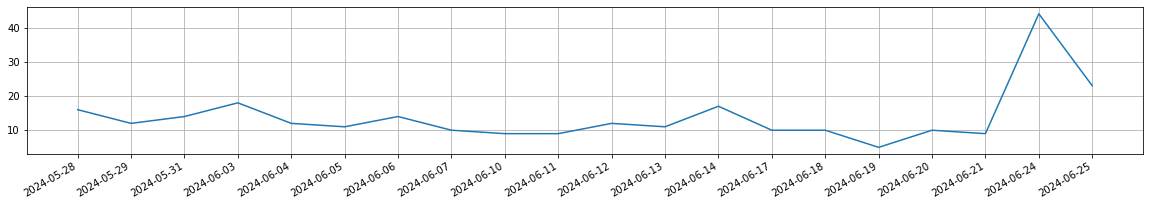

In [27]:
gera_grafico(list_datas, d05_count)

### Gráfico 10

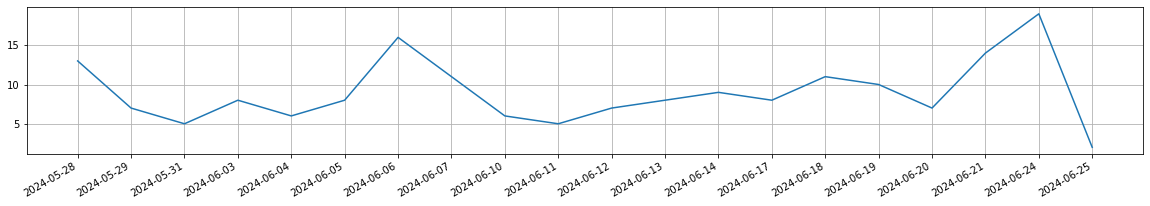

In [28]:
gera_grafico(list_datas, d10_count)

### Gráfico 15

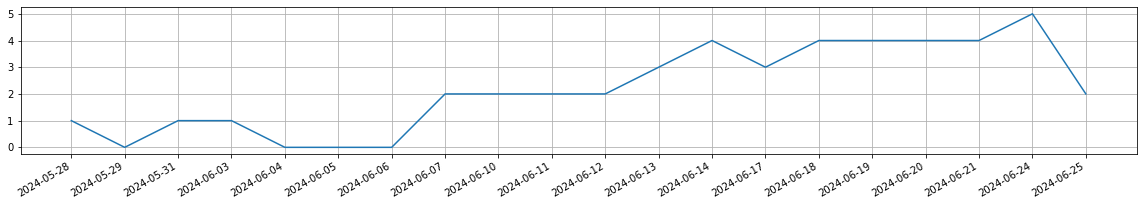

In [29]:
gera_grafico(list_datas, d15_count)

### Gráfico 20

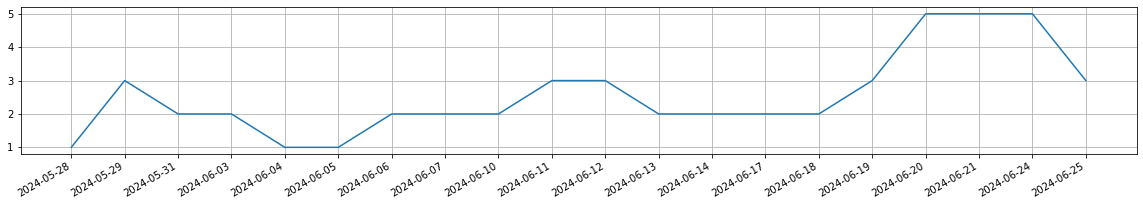

In [30]:
gera_grafico(list_datas, d20_count)

### Gráfico 25

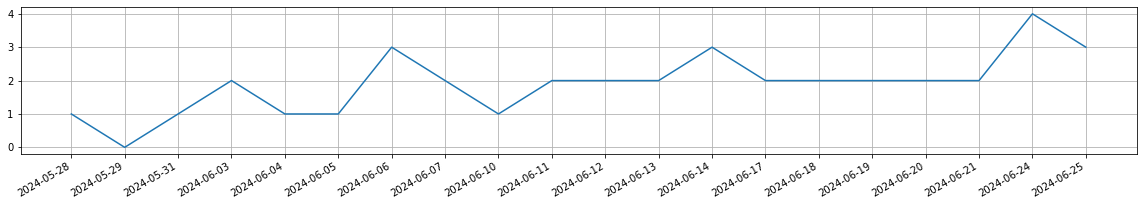

In [31]:
gera_grafico(list_datas, d25_count)

### ======================================== TESTES ========================================

In [ ]:
bla

### Comparar Maiores Lucros

In [ ]:
df_original = df.copy()

In [ ]:
df = df_original.copy()

In [ ]:
df_teste = df_original.copy()

In [ ]:
dt_max = df_teste["dtPregao"].max()
df_teste = df_teste.loc[df_teste["dtPregao"] != dt_max]

In [ ]:
d05 = monta_tabela(monta_df_periodos(df_teste, 5), 3000000, '1.0%', 5, 2)
d05

In [ ]:
consulta_acao(df_teste, "RAIZ4")

### ----------------------------------------------------------------------------

In [ ]:
df_1 = monta_lucro_periodo(df, 10, 0, True)
df_2 = monta_lucro_periodo(df, 10, 1, True)

In [ ]:
df_final = df_1.copy()
df_final['posicao ant'], df_final['mudanca'] = [
    df_2['posicao']
    , df_2['posicao'] - df_1['posicao']
]
df_final['posicao ant'] = df_final['posicao ant'].fillna(0).astype('int')
df_final['mudanca'] = df_final['mudanca'].fillna(0).astype('int')

In [ ]:
df_final.sort_values(["mudanca"], ascending=False)

In [ ]:
df_final.sort_values(["mudanca"], ascending=False).loc[df_final['posicao ant'] <= 10]

In [ ]:
df_1

In [ ]:
df_2

In [ ]:
# dfDtMin = df5d.loc[(df["dtPregao"] == dt_min_5d) & (df["cdAcao"] == 'PTBL3')]

df5d  = busca_periodos(df, 5)
df25d = busca_periodos(df, 25)

dt_min_5d  = df5d["dtPregao"].min()
dt_min_25d = df25d["dtPregao"].min()
dt_max     = df5d["dtPregao"].max()
dfDtMin5d  = df5d.loc[(df5d["dtPregao"] == dt_min_5d)].set_index(["cdAcao"])
dfDtMin25d = df25d.loc[(df25d["dtPregao"] == dt_min_25d)].set_index(["cdAcao"])
dfDtMax    = df5d.loc[(df5d["dtPregao"] == dt_max)].set_index(["cdAcao"])
dfAvgVol5d  = busca_media(df5d, "vrVolume", "vol").set_index(["cdAcao"])
dfAvgVol25d = busca_media(df25d, "vrVolume", "vol").set_index(["cdAcao"])

In [ ]:
 dfPc5d = pd.DataFrame({
         "dtInicio":dfDtMin5d["dtPregao"] ,"dtFim":dfDtMax["dtPregao"]
        ,"vrInicio":dfDtMin5d["vrFech"]   ,"vrFim":dfDtMax["vrFech"]
        ,"pcPeriodo":((dfDtMax["vrFech"] - dfDtMin5d["vrFech"]) / dfDtMin5d["vrFech"]) * 100
        ,"avgVol":dfAvgVol5d["vol"]
    })

In [ ]:
 dfPc25d = pd.DataFrame({
         "dtInicio":dfDtMin25d["dtPregao"] ,"dtFim":dfDtMax["dtPregao"]
        ,"vrInicio":dfDtMin25d["vrFech"]   ,"vrFim":dfDtMax["vrFech"]
        ,"pcPeriodo":((dfDtMax["vrFech"] - dfDtMin25d["vrFech"]) / dfDtMin25d["vrFech"]) * 100
        ,"avgVol":dfAvgVol25d["vol"]
    })

In [ ]:
# dfPc25d.sort_values(["pcPeriodo"], ascending=False).loc[(dfPc25d["avgVol"] > 6000000)]

In [ ]:
# dfPc5d.sort_values(["pcPeriodo"], ascending=False).loc[(dfPc5d["avgVol"] > 6000000)]

In [ ]:
# dfPc25d['pcPeriodo']

In [ ]:
df_temp = monta_lucro_periodo(df, 25, 0, True)
# monta_lucro_periodo(df, 25, 0)

In [ ]:
# df_temp

In [ ]:
df_n_dias = busca_periodos(df, 26)

dias_ant = 2
i = 0
while i <= dias_ant:
    dt_max  = df_n_dias["dtPregao"].max()
    df_n_dias = df_n_dias.loc[df_n_dias["dtPregao"] != dt_max]
    i += 1
    
dt_max

In [ ]:
### 25 dias, Order by 0.5% # df05.loc[(df05["AvgVol"] > 6000000) & (df05["0.5%"] >= 23) & (df05["AvgVrFech"] > 5)].sort_values(["0.5%", "1.0%", "1.5%", "2.0%"], ascending=False)
### 20 dias, Order by 0.5% # df05_20d.loc[(df05_20d["AvgVol"] > 6000000) & (df05_20d["0.5%"] >= 19) & (df05_20d["AvgVrFech"] > 5)].sort_values(["0.5%", "1.0%", "1.5%", "2.0%"], ascending=False)
### 15 dias, Order by 0.5% # df05_15d.loc[(df05_15d["AvgVol"] > 6000000) & (df05_15d["0.5%"] >= 15) & (df05_15d["AvgVrFech"] > 5)].sort_values(["0.5%", "1.0%", "1.5%", "2.0%"], ascending=False)

## Definindo valores para compra

In [ ]:
# Valor disponível para cmp / 1000
# Valor da ação no leilão
vr_corretagem = 9.8
emolumentos = 0.000325
acao = 'LIGT3'
vr_disp = 110
vr_acao_leilao = 1148 / 100
vr_qtd = round((vr_disp * 1000) / (vr_acao_leilao * 100)) * 100

In [ ]:
vr_cmp = round(vr_acao_leilao * 1.014, 2)

vr_tot_cmp = vr_acao_leilao * vr_qtd
corret_cmp = vr_corretagem + (vr_tot_cmp * emolumentos)
vr_tot_liq_cmp = vr_tot_cmp + corret_cmp

vr_acao_vnd_10 = float('{0:.2f}'.format(vr_acao_leilao * 1.0108 + 0.01))
vr_tot_vnd_10 = vr_acao_vnd_10 * vr_qtd
corret_vnd_10 = vr_corretagem + (vr_tot_vnd_10 * emolumentos)
vr_tot_liq_vnd_10 = vr_tot_vnd_10 - corret_vnd_10

vr_acao_vnd_15 = float('{0:.2f}'.format(vr_acao_leilao * 1.0158 + 0.01))
vr_tot_vnd_15 = vr_acao_vnd_15 * vr_qtd
corret_vnd_15 = vr_corretagem + (vr_tot_vnd_15 * emolumentos)
vr_tot_liq_vnd_15 = vr_tot_vnd_15 - corret_vnd_15

In [ ]:
d = {'Compra':     ['Quantidade', 'Valor Leilão', 'Total', 'Total líquido', 'Corretagem Compra'],
     ' ':          [vr_qtd, vr_acao_leilao, vr_tot_cmp, vr_tot_liq_cmp, corret_cmp],
     'Venda 1,0%': ['Valor compra', 'Valor', 'Total', 'Total líquido', 'Corretagem Venda'],
     '1,0%':       [vr_cmp, vr_acao_vnd_10, vr_tot_vnd_10, vr_tot_liq_vnd_10, corret_vnd_10],
     'Venda 1,5%': [' ', 'Valor', 'Total', 'Total líquido', 'Corretagem Venda'],
     '1,5%':       [' ', vr_acao_vnd_15, vr_tot_vnd_15, vr_tot_liq_vnd_15, corret_vnd_15]
    }
df_calc = pd.DataFrame(data=d)
df_calc

In [ ]:
d2 = {'Index':      ['Quantidade', 'Valor', 'Total', 'Total líquido', 'Corretagem'],
      'Compra':     [vr_qtd, vr_cmp, vr_tot_cmp, vr_tot_liq_cmp, corret_cmp],
      'Venda 1.0%': [vr_qtd, vr_acao_vnd_10, vr_tot_vnd_10, vr_tot_liq_vnd_10, corret_vnd_10],
      'Venda 1.5%': [vr_qtd, vr_acao_vnd_15, vr_tot_vnd_15, vr_tot_liq_vnd_15, corret_vnd_15]
     }
df_calc2 = pd.DataFrame(data=d2)
df_calc2.set_index('Index')
df_calc2

In [ ]:
time.asctime( time.localtime(time.time()) )